In [1]:
import pandas as pd
import numpy as np
import glob
from langdetect import detect, LangDetectException


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler


In [2]:

MAX_ROWS = 50000

# Function to detect Russian sentences and set them to None
def detect_russian_sentence(df, text_column):
    rows_to_keep = []
    rows_to_replace = []

    for index, row in df.iterrows():
        try:
            if detect(row[text_column]) == 'ru':
                rows_to_replace.append(index)
            else:
                rows_to_keep.append(index)
        except LangDetectException:
            rows_to_keep.append(index)

    #Drop rows with Russian content 
    df = df.iloc[rows_to_keep].copy()

    #Start adding new rows in case of removal
    if rows_to_replace:
        additional_row_needed = len(rows_to_replace)
        extra_rows = df.sample(n=additional_row_needed, replace=True).copy()
        df = pd.concat([df, extra_rows], ignore_index=True)

    return df



# Get a list of all CSV files in the troll data directory
troll_files = glob.glob("../russian-troll-tweets-master/*.csv")

troll_df_list = []
troll_rows = 0



#Load troll datasets
#troll_df_list = [pd.read_csv(file, nrows=100000) for file in troll_files]
for file in troll_files:
    remaining_rows = MAX_ROWS - troll_rows
    if remaining_rows <= 0:
        break
    df = pd.read_csv(file, nrows=min(remaining_rows, 10000))
    #Detect russian sentence(i will check it only on troll datasets since non-troll datasets dont contains any russian words even)
    df = detect_russian_sentence(df, 'content')

    troll_df_list.append(df)
    troll_rows += len(df)
    
troll_df = pd.concat(troll_df_list, ignore_index=True)

non_troll_df= pd.read_csv("../Non-troll-Twitter/train-balanced-sarcasm.csv", nrows=50000)

#Standardize for column names for merging

troll_df.rename(columns={'external_author_id':'id','author': 'author', 'content': 'text', 'publish_date': 'created_at'}, inplace=True)
non_troll_df.rename(columns={'created_utc': 'created_at', 'comment': 'text', 'author': 'author'}, inplace=True)


#Add label column for indicatin troll and non troll
troll_df['label'] = 1
non_troll_df['label'] = 0

# Create a unique ID for the non-troll dataset
non_troll_df['id'] = range(1, len(non_troll_df) + 1)






###EDA FOR interaction and engagement features

In [3]:

#Basic statistics
troll_stats =troll_df[['followers', 'following', 'updates']].describe()
non_troll_stats =non_troll_df[['ups', 'downs', 'score']].describe()

print("Troll Data Stats:\n", troll_stats)
print("Non-Troll Data Stats:\n", non_troll_stats)




Troll Data Stats:
           followers     following       updates
count  50000.000000  50000.000000  50000.000000
mean    4396.734720   2393.391500   8009.908360
std     6030.544588   2467.395335  11267.962073
min        0.000000      0.000000      1.000000
25%      319.000000    562.000000    959.000000
50%     1163.000000   1216.000000   2369.000000
75%     6406.000000   4493.000000  10740.250000
max    20040.000000  12132.000000  38069.000000
Non-Troll Data Stats:
                ups         downs         score
count  50000.00000  50000.000000  50000.000000
mean       0.94830     -0.781800      8.166640
std       20.01309      0.413028     48.595359
min      -85.00000     -1.000000   -188.000000
25%       -1.00000     -1.000000      1.000000
50%       -1.00000     -1.000000      2.000000
75%       -1.00000     -1.000000      5.000000
max     1737.00000      0.000000   3192.000000


In [4]:
#Clean Data
#Remove rows with infinite or extremely large values
troll_df.replace([np.inf, -np.inf], np.nan, inplace=True)
non_troll_df.replace([np.inf, -np.inf], np.nan, inplace=True)

troll_df.dropna(subset=['followers', 'following', 'updates'], inplace=True)
non_troll_df.dropna(subset=['ups', 'downs', 'score'], inplace=True)

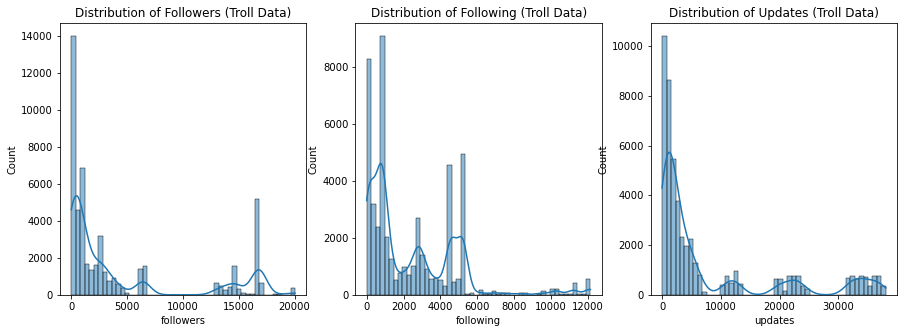

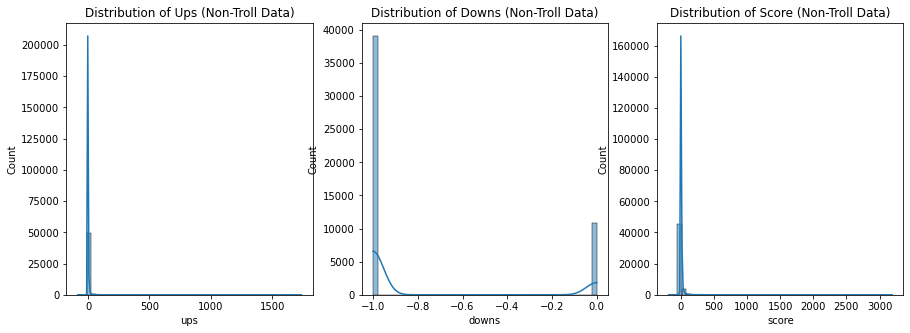

In [5]:
###PLOT 

##For troll
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(troll_df['followers'], bins=50, kde=True)
plt.title('Distribution of Followers (Troll Data)')


plt.subplot(1,3,2)
sns.histplot(troll_df['following'], bins=50, kde=True)
plt.title('Distribution of Following (Troll Data)')


plt.subplot(1,3,3)
sns.histplot(troll_df['updates'], bins=50, kde=True)
plt.title('Distribution of Updates (Troll Data)')
plt.show()

###For non_troll
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.histplot(non_troll_df['ups'], bins=50, kde=True)
plt.title('Distribution of Ups (Non-Troll Data)')

plt.subplot(1, 3, 2)
sns.histplot(non_troll_df['downs'], bins=50, kde=True)
plt.title('Distribution of Downs (Non-Troll Data)')

plt.subplot(1, 3, 3)
sns.histplot(non_troll_df['score'], bins=50, kde=True)
plt.title('Distribution of Score (Non-Troll Data)')
plt.show()

In [6]:
#Calculating interaction and engagement 



#define epsilon to avoid division by zero
epsilon = 1e-6

# Use Min-Max Scaler for normalization
scaler = MinMaxScaler()

# Normalize relevant columns i
troll_df[['followers', 'following', 'updates']] = scaler.fit_transform(troll_df[['followers', 'following', 'updates']])

# Calculate interaction and engagement
troll_df['interaction'] = troll_df['followers'] / (troll_df['following'] + 1)
troll_df['engagement'] = troll_df['updates'] / (troll_df['followers'] + 1)

# Normalize interaction and engagement 
troll_df[['interaction']] = scaler.fit_transform(troll_df[['interaction']].values.reshape(-1, 1))
troll_df[['engagement']] = scaler.fit_transform(troll_df[['engagement']].values.reshape(-1, 1))

# Normalize the score column 
non_troll_df[['score']] = scaler.fit_transform(non_troll_df[['score']].values.reshape(-1, 1))

# Calculate interaction and engagement using  normalized score
non_troll_df['interaction'] = non_troll_df['score']
non_troll_df['engagement'] = np.log1p(non_troll_df['score'] * 100)

# Normalize engagement to bring to normal values
non_troll_df[['engagement']] = scaler.fit_transform(non_troll_df[['engagement']].values.reshape(-1, 1))

In [7]:
troll_stats =troll_df[['interaction', 'engagement']].describe()
non_troll_stats =non_troll_df[['interaction', 'engagement']].describe()

print("Troll Data Stats:\n", troll_stats)
print("Non-Troll Data Stats:\n", non_troll_stats)

Troll Data Stats:
         interaction    engagement
count  50000.000000  50000.000000
mean       0.213059      0.247690
std        0.280203      0.292795
min        0.000000      0.000000
25%        0.020622      0.045476
50%        0.069985      0.105939
75%        0.302205      0.393624
max        1.000000      1.000000
Non-Troll Data Stats:
         interaction    engagement
count  50000.000000  50000.000000
mean       0.058037      0.413910
std        0.014377      0.021046
min        0.000000      0.000000
25%        0.055917      0.408616
50%        0.056213      0.409587
75%        0.057101      0.412472
max        1.000000      1.000000


In [8]:
#Select relevant columns
troll_df = troll_df[['id', 'label', 'author', 'text', 'interaction', 'engagement', 'created_at']]
non_troll_df = non_troll_df[['id', 'label', 'author', 'text', 'interaction', 'engagement', 'created_at']]


#Combine datasets
merged_df = pd.concat([troll_df, non_troll_df], ignore_index=True)
# Remove duplicates
#merged_df = merged_df.drop_duplicates()

print(f"Final dataset shape: {merged_df.shape}")
print(f"Troll count: {merged_df[merged_df['label'] == 1].shape[0]}")
print(f"Non-troll count: {merged_df[merged_df['label'] == 0].shape[0]}")

#Save merged dataset
merged_df.to_csv('../Merged_troll_non_troll/merged_dataset100000.csv', index=False )

Final dataset shape: (100000, 7)
Troll count: 50000
Non-troll count: 50000
